### PB: EM, HR, IC

* The following notebook is trained on data generated from revised R script [Oct 12 2017]
    * Exact Match [1] and Homozygous [0] Reference data points
    * Removed all data points with Gtcons and GTconswithoutXX -1
* 5k randomly selected deletions test data was also processed through same R script
* Balanced Training Set for GTcons labels:
    * 200 Hom Var
    * 200 Hom Ref
    * 200 Het Var
* **Train/Prediction Label:** EM, HR, IC

In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [2]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/PB_EM_HR_IC_HG002_DEL_min1.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/PB_EM_HR_IC_HG002_DEL_min1.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1,HG002,23,72766323,72811839,-45516,Deletion,Deletion,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/PB_HG002_DEL_min1.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/PB_HG002_DEL_min1.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1,HG002,859,37568322,37568587,-115,Insertion,Deletion,0,0,...,149.0,209.0,4.0,16.0,13276.22581,7611.37823,31.0,8407.903226,4770.945293,31.0


In [4]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Label'}

In [5]:
### Drop columns that are not shared by both dataframes
df_train.drop(['GTcons'], axis=1, inplace = True)
df_train.drop(['GTconswithoutpacbio.GT'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [6]:
df_train.head(1)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1,72766323,72811839,-45516,0,0,4,0.076523,110,0.059979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [8]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict',
 'GTcons',
 'GTconswithoutpacbio.GT',
 'GTsupp',
 'SVtype',
 'id',
 'sample',
 'type'}

In [9]:
### Drop columns that are not shared by both dataframes
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconswithoutpacbio.GT'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [10]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1,72766323,72811839,-45516,0,0,4,0.076523,110,0.059979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,96139975,96142391,-2416,0,0,0,0.000000,2,0.014487,...,173.0,251.0,3.0,8.0,16036.15385,7164.654453,26.0,10075.07692,4504.705061,26.0
2,1,109690878,109690918,-39,0,0,0,0.000000,1,0.400000,...,222.0,197.0,11.0,9.0,20597.94118,5844.767921,17.0,12582.47059,3520.607336,17.0


In [11]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/2990 with 22 missing, elapsed time: 2.406
Imputing row 101/2990 with 0 missing, elapsed time: 2.451
Imputing row 201/2990 with 0 missing, elapsed time: 2.452
Imputing row 301/2990 with 0 missing, elapsed time: 2.453
Imputing row 401/2990 with 0 missing, elapsed time: 2.453
Imputing row 501/2990 with 0 missing, elapsed time: 2.454
Imputing row 601/2990 with 0 missing, elapsed time: 2.455
Imputing row 701/2990 with 0 missing, elapsed time: 2.455
Imputing row 801/2990 with 0 missing, elapsed time: 2.456
Imputing row 901/2990 with 0 missing, elapsed time: 2.456
Imputing row 1001/2990 with 0 missing, elapsed time: 2.457
Imputing row 1101/2990 with 0 missing, elapsed time: 2.457
Imputing row 1201/2990 with 0 missing, elapsed time: 2.458
Imputing row 1301/2990 with 0 missing, elapsed time: 2.458
Imputing row 1401/2990 with 0 missing, elapsed time: 2.461
Imputing row 1501/2990 with 0 missing, elapsed time: 2.461
Imputing row 1601/2990 with 0 missing, elapsed time: 2.462
Imputing

In [12]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1.0,72766323.0,72811839.0,-45516.0,0.0,0.0,4.0,0.076523,110.0,0.059979,...,171.065556,245.677939,0.0,11.868332,18183.326498,6674.615354,38.362951,11504.792882,4183.611492,38.362951
1,1.0,96139975.0,96142391.0,-2416.0,0.0,0.0,0.0,0.000000,2.0,0.014487,...,173.000000,251.000000,3.0,8.000000,16036.153850,7164.654453,26.000000,10075.076920,4504.705061,26.000000
2,1.0,109690878.0,109690918.0,-39.0,0.0,0.0,0.0,0.000000,1.0,0.400000,...,222.000000,197.000000,11.0,9.000000,20597.941180,5844.767921,17.000000,12582.470590,3520.607336,17.000000


In [13]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = X['Label']

In [14]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

1.0    1000
0.0    1000
2.0     990
dtype: int64

In [15]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [16]:
# Remove labels from feature set
X.drop(['Label'],axis=1, inplace = True)

In [17]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.
   **FYI**: [see description below of the SVanalyzer data](#svan_1)
       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
       * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are:
           * Exact Match (1)
           * Homozygous Reference (0)
           * Inaccurate Call (2)
           
   * The trained model will be used to predict labels for 5000 randomly selected deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

<a id='svan_1'></a>
* **Reminder - SVanalyzer data description:** 
     * **1000 Exact Match**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Homozygous Reference**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Inaccurate Calls**: 1000 datapoints were randomly selected from the following
[svanalyzer_union_170509_refalt.2.2.2.clustered.uniquecalls.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
   
   * Source of Features: svviz, GA4GH [tandem repeat, segmental duplications, refN], R analysis [consensus genotype, GTsup]   
    

** Train Random Forest Classifier **

<a id='train_test'></a>

In [18]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)

In [19]:
# Train Random Forest Classifier
model = RandomForestClassifier() 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [ ]:
# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



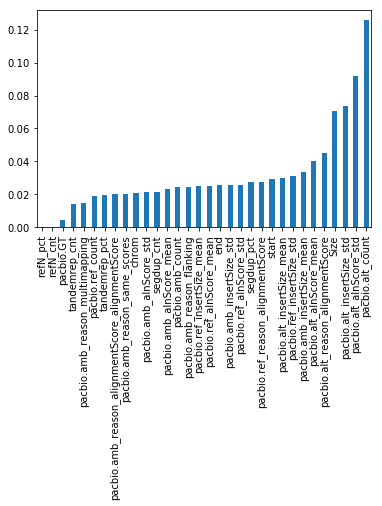

In [20]:
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feature_importances.sort()
feature_importances.plot.bar()

In [21]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

2.0    705
0.0    710
1.0    678
dtype: int64

In [22]:
pred = model.predict(X_test)

In [23]:
precision_score(pred, y_test, average='micro') 

0.73244147157190631

In [24]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,Size,chrom,end,pacbio.GT,pacbio.alt_alnScore_mean,pacbio.alt_alnScore_std,pacbio.alt_count,pacbio.alt_insertSize_mean,pacbio.alt_insertSize_std,pacbio.alt_reason_alignmentScore,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
2572,-232.0,3.0,9601738.0,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,...,9325.050000,4177.258335,40.0,0.0,0.0,0.0,0.0,9601506.0,1.0,1.000000
1230,-21.0,13.0,108428179.0,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,...,10434.102560,4670.597677,39.0,0.0,0.0,0.0,0.0,108428158.0,0.0,0.000000
316,-366.0,16.0,59808677.0,1.0,14908.18182,5964.528067,11.0,10105.72727,4245.479566,11.0,...,9236.444444,3872.326627,27.0,0.0,0.0,0.0,0.0,59808311.0,6.0,0.379781
2752,-365.0,6.0,43626330.0,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,...,9207.861111,3842.198641,36.0,0.0,0.0,0.0,0.0,43625965.0,2.0,0.175342
2189,-133.0,12.0,128726483.0,-1.0,19367.03226,7310.282645,31.0,12599.00000,4730.513571,31.0,...,4135.000000,3197.444917,3.0,0.0,0.0,1.0,1.0,128726350.0,4.0,0.518797


In [25]:
labels = pd.DataFrame(y_test)

In [26]:
df_Xtest['predicted_label'] = pred
df_Xtest['Label'] = df_train['Label']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [27]:
pd.value_counts(df_Xtest['Label'].values, sort=False)

0    290
1    322
2    285
dtype: int64

In [28]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

0.0    318
1.0    355
2.0    224
dtype: int64

In [29]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['Label']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[234   8  48]
 [  7 281  34]
 [ 77  66 142]]


In [30]:
df_Xtest['Label'].replace(0, 'Homozygous_Reference', inplace=True)
df_Xtest['Label'].replace(1, 'Exact_Match', inplace=True)
df_Xtest['Label'].replace(2, 'Inaccurate_Call', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Exact_Match', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Inaccurate_Call', inplace=True)

In [31]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Exact_Match,Homozygous_Reference,Inaccurate_Call,All
True,,,,
Exact_Match,281,7,34,322
Homozygous_Reference,8,234,48,290
Inaccurate_Call,66,77,142,285
All,355,318,224,897


In [32]:
from sklearn.metrics import classification_report
print(classification_report(predict,ytest))

                      precision    recall  f1-score   support

         Exact_Match       0.87      0.79      0.83       355
Homozygous_Reference       0.81      0.74      0.77       318
     Inaccurate_Call       0.50      0.63      0.56       224

         avg / total       0.76      0.73      0.74       897



***
Predict
***

Description:

   * In the [previous section](#machine_learning) the model was trained on svanalyzer data.
   **FYI**: [see description below of the SVanalyzer data](#svan_2)
       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
       * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are:
           * Exact Match (1)
           * Homozygous Reference (0)
           * Inaccurate Call (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

<a id='svan_2'></a>
* **Reminder - SVanalyzer data description:** 
     * **1000 Exact Match**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Homozygous Reference**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Inaccurate Calls**: 1000 datapoints were randomly selected from the following
[svanalyzer_union_170509_refalt.2.2.2.clustered.uniquecalls.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
   
   * Source of Features: svviz, GA4GH [tandem repeat, segmental duplications, refN], R analysis [consensus genotype, GTsup]   
   

** Load Data **

In [33]:
X2 = df_test

** Impute missing values using KNN **

In [34]:
#Convert dataframe to matrix
X2=X2.as_matrix()

#Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/3281 with 0 missing, elapsed time: 2.737
Imputing row 101/3281 with 0 missing, elapsed time: 2.738
Imputing row 201/3281 with 0 missing, elapsed time: 2.738
Imputing row 301/3281 with 0 missing, elapsed time: 2.740
Imputing row 401/3281 with 0 missing, elapsed time: 2.742
Imputing row 501/3281 with 0 missing, elapsed time: 2.744
Imputing row 601/3281 with 0 missing, elapsed time: 2.745
Imputing row 701/3281 with 0 missing, elapsed time: 2.746
Imputing row 801/3281 with 0 missing, elapsed time: 2.748
Imputing row 901/3281 with 0 missing, elapsed time: 2.750
Imputing row 1001/3281 with 0 missing, elapsed time: 2.751
Imputing row 1101/3281 with 0 missing, elapsed time: 2.753
Imputing row 1201/3281 with 0 missing, elapsed time: 2.756
Imputing row 1301/3281 with 0 missing, elapsed time: 2.757
Imputing row 1401/3281 with 0 missing, elapsed time: 2.758
Imputing row 1501/3281 with 0 missing, elapsed time: 2.759
Imputing row 1601/3281 with 0 missing, elapsed time: 2.760
Imputing 

In [35]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.000000,3.0,0.818868,...,149.0,209.0,4.0,16.0,13276.22581,7611.378230,31.0,8407.903226,4770.945293,31.0
1,1.0,112835104.0,112837661.0,-2534.0,0.0,0.0,1.0,0.890888,6.0,0.460305,...,159.0,270.0,8.0,9.0,11538.50000,5911.500000,2.0,7826.000000,4015.000000,2.0
2,1.0,3557049.0,3557087.0,-37.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,151.0,207.0,0.0,10.0,8573.00000,4836.734918,3.0,6021.000000,3561.905763,3.0


In [36]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.000000,3.0,0.818868,...,149.0,209.0,4.0,16.0,13276.22581,7611.378230,31.0,8407.903226,4770.945293,31.0
1,1.0,112835104.0,112837661.0,-2534.0,0.0,0.0,1.0,0.890888,6.0,0.460305,...,159.0,270.0,8.0,9.0,11538.50000,5911.500000,2.0,7826.000000,4015.000000,2.0
2,1.0,3557049.0,3557087.0,-37.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,151.0,207.0,0.0,10.0,8573.00000,4836.734918,3.0,6021.000000,3561.905763,3.0


In [37]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

<a id='prediction_step'></a>

In [38]:
pred = model.predict(X5)

In [39]:
pred_prob = model.predict_proba(X5)

In [40]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTcons'] = df_test_2['GTcons']
X5['GTsupp'] = df_test_2['GTsupp']
X5['GTconswithoutpacbio.GT'] = df_test_2['GTconswithoutpacbio.GT']

In [41]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/PB_pred_prob_DEL_SVanalyzer_revised_EMHRIC.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [42]:
X6 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/PB_pred_prob_DEL_SVanalyzer_revised_EMHRIC.csv')

In [43]:
X6.rename(columns={'1': 'Homozygous_Reference_SVan_predprob_PB'}, inplace=True)
X6.rename(columns={'2': 'Exact_Match_predprob_PB'}, inplace=True)
X6.rename(columns={'3': 'Inaccurate_Call_predprob_PB'}, inplace=True)
X6.rename(columns={'predicted_label': 'PB_predicted_EMHRIC_label'}, inplace=True)

In [ ]:
X6.head(3)

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/PB_final_df_DEL_SVanalyzer_revised_EMHRIC.csv', index=False)

***
Label Analysis
***

Description:
  * Comparison of model predicted labels [Exact Match, Homozygous Reference, Inaccurate Calls] to consensus genotype for the 5000 randomly selected datapoints from union_refalt.vcf for HG002 only

In [44]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTcons']
predict = X6['PB_predicted_EMHRIC_label']
print(confusion_matrix(consensus_GT, predict))

[[ 547   34  207]
 [  18 1696   98]
 [   4  661   16]]


In [45]:
from sklearn.metrics import confusion_matrix
GT_without_XX = X6['GTconswithoutpacbio.GT']
predict = X6['PB_predicted_EMHRIC_label']
print(confusion_matrix(consensus_GT, predict))

[[ 547   34  207]
 [  18 1696   98]
 [   4  661   16]]


In [46]:
pd.value_counts(X6['GTconswithoutpacbio.GT'].values, sort=False)

0     788
2     681
1    1812
dtype: int64

In [47]:
pd.value_counts(X6['GTcons'].values, sort=False)

0     788
2     681
1    1812
dtype: int64

In [48]:
X6['GTcons'].replace(-1, 'Unknown', inplace=True)
X6['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)
X6['PB_predicted_EMHRIC_label'].replace(0.0, 'Homozygous_Reference_SVan', inplace=True)
X6['PB_predicted_EMHRIC_label'].replace(1.0, 'Exact_Match', inplace=True)
X6['PB_predicted_EMHRIC_label'].replace(2.0, 'Inaccurate_Call', inplace=True)

In [49]:
X6['GTconswithoutpacbio.GT'].replace(-1, 'Unknown', inplace=True)
X6['GTconswithoutpacbio.GT'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTconswithoutpacbio.GT'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTconswithoutpacbio.GT'].replace(2, 'Homozygous_Variant', inplace=True)

** Compare SVanalyzer Labels to GTcons **

In [50]:
pd.crosstab(consensus_GT, predict, rownames=['GTcons'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons,,,,
Heterozygous_Variant,1696,18,98,1812
Homozygous_Reference,34,547,207,788
Homozygous_Variant,661,4,16,681
All,2391,569,321,3281


** Compare SVanalyzer Labels to LOO Consensus GT **

In [51]:
pd.crosstab(GT_without_XX, predict, rownames=['GTcons_withoutXX'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons_withoutXX,,,,
Heterozygous_Variant,1696,18,98,1812
Homozygous_Reference,34,547,207,788
Homozygous_Variant,661,4,16,681
All,2391,569,321,3281


** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following svanalyzer labels:
    * Homozygous Reference: 0 
    * Exact Match: 1 
    * Inaccurate Call: 2 
* Here **high confidence labels** are the labels predicted by the model that were also assigned a predict probability of either 0.9 or 1
* The following is an analysis of predicted svanalyzer labels with predict probability >0.9

In [52]:
high_conf_labels = X6[(X6['Homozygous_Reference_SVan_predprob_PB'] == 1) | (X6['Homozygous_Reference_SVan_predprob_PB'] == 0.9) | (X6['Exact_Match_predprob_PB'] == 1) | (X6['Exact_Match_predprob_PB'] == 0.9) | (X6['Inaccurate_Call_predprob_PB'] == 1) | (X6['Inaccurate_Call_predprob_PB'] == 0.9)]

** Consensus Genotype versus SVanalyzer Labels **

In [53]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['PB_predicted_EMHRIC_label']
pd.crosstab(consensus_GT, predict, rownames=['GTcons'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons,,,,
Heterozygous_Variant,867,0,3,870
Homozygous_Reference,5,189,22,216
Homozygous_Variant,392,1,1,394
All,1264,190,26,1480


** LOO Genotype versus SVanalyzer Labels **

In [54]:
consensus_GT = high_conf_labels['GTconswithoutpacbio.GT']
predict = high_conf_labels['PB_predicted_EMHRIC_label']
pd.crosstab(consensus_GT, predict, rownames=['GTcons_without_XX'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons_without_XX,,,,
Heterozygous_Variant,867,0,3,870
Homozygous_Reference,5,189,22,216
Homozygous_Variant,392,1,1,394
All,1264,190,26,1480


***
Graphs
***

** Exact Match **

In [55]:
em = X5['predicted_label'] == 1.0
exact_match = X5[em]

In [56]:
exact_match.head(1)

,Size,chrom,end,pacbio.GT,pacbio.alt_alnScore_mean,pacbio.alt_alnScore_std,pacbio.alt_count,pacbio.alt_insertSize_mean,pacbio.alt_insertSize_std,pacbio.alt_reason_alignmentScore,...,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp,GTconswithoutpacbio.GT
1,-2534,1,112837661,-1.0,20099.13333,6963.566106,45.0,12729.24444,4313.52163,45.0,...,0.0,1.0,0.890888,112835104,6.0,0.460305,1.0,2,1,2


In [57]:
output_notebook()

Loading BokehJS ...

In [58]:
p = figure()
p = Histogram(exact_match, values='GTcons', title='Exact_Match_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

** Homozygous Reference **

In [59]:
hr = X5['predicted_label'] == 0.0
hom_ref = X5[hr]
hom_ref.head(1)

,Size,chrom,end,pacbio.GT,pacbio.alt_alnScore_mean,pacbio.alt_alnScore_std,pacbio.alt_count,pacbio.alt_insertSize_mean,pacbio.alt_insertSize_std,pacbio.alt_reason_alignmentScore,...,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp,GTconswithoutpacbio.GT
8,-20,1,29719393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,29719372,1.0,1.0,0.0,0,4,0


In [60]:
p = figure()
p = Histogram(hom_ref, values='GTcons', title='Homozygous_Reference_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

** Inaccurate Call **

In [61]:
ic = X5['predicted_label'] == 2.0
inac_call = X5[ic]
inac_call.head(1)

,Size,chrom,end,pacbio.GT,pacbio.alt_alnScore_mean,pacbio.alt_alnScore_std,pacbio.alt_count,pacbio.alt_insertSize_mean,pacbio.alt_insertSize_std,pacbio.alt_reason_alignmentScore,...,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp,GTconswithoutpacbio.GT
0,-115,1,37568587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,37568322,3.0,0.818868,2.0,0,4,0


In [62]:
p = figure()
p = Histogram(inac_call, values='GTcons', title='Inaccurate_Call_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)